# Transfer Learning and Fine-tuning

Transfer learning is a technique that shortcuts having to train complicated models completely from scratch. It allows you to take a piece of another model that has already been trained on a related task for reusing purposes in a new model. 

This is useful for rapidly developing new models as well as customizing models in resource constrained environments like browsers and mobile devices. 

Most often when doing transfer learning, we don't adjust the weights of the original model. Instead we remove the final layer and train a new one (often fairly shallow) model on top of the output of the truncated model.

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

## Download the data

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

68608000/68606236 [==============================] - 12s 0us/step
Found 2000 files belonging to 2 classes.


In [3]:
# create the validation set
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


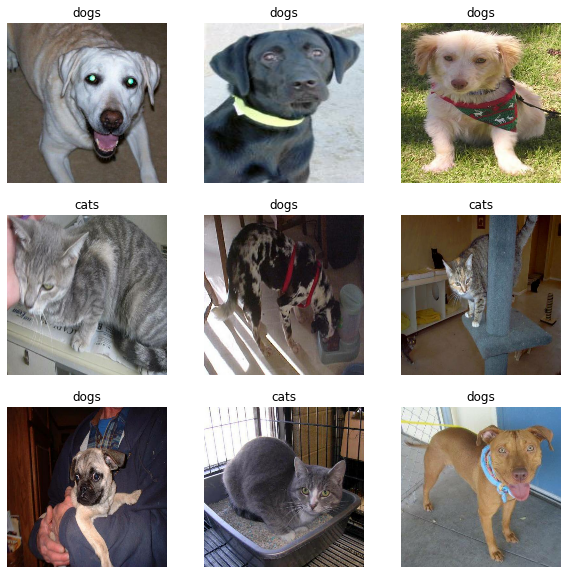

In [4]:
# show the first nine images

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
# create test set

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


## Configure the dataset for performance

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
# augmentate the data 

data_aug = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

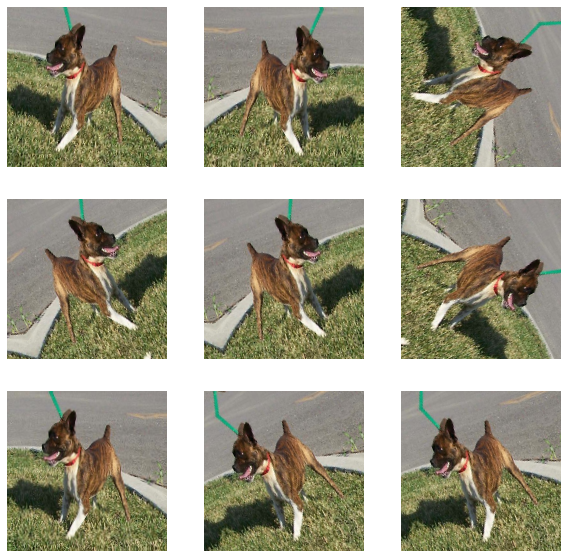

In [10]:
# check the augmented layers on one image

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_aug(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [11]:
# rescale the pixel values to match the expected values of the MobileNetV2 model

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [14]:
preprocess_input

<function tensorflow.python.keras.applications.mobilenet_v2.preprocess_input(x, data_format=None)>

## Create the Base model from the pre-trained Convnets

MobileNet V2 model is pre-trained on the ImageNet dataset containing over 1.4M images and 1000 classes. 

First we need to pick which layer of the MobileNet v2 will be used for feature extraction. The very last classification layer is not very useful. Instead, common practice is to use the **bottleneck layer**, the last layer before the flatten operation. 

In [16]:
# instantiate the MobileNet V2

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                             include_top=False,
                                             weights='imagenet')

9412608/9406464 [==============================] - 1s 0us/step


In [19]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [17]:
image_batch, label_batch = next(iter(train_dataset)) # the next iteration in the dataset, so the first image
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature Extraction

In this step, we freeze the convolutional base created from the step before, and use it a feature extractor. Additionally, we will add a classifier on top of it and train the top-level classifier.

In [20]:
# freeze the convolutional base
base_model.trainable=False

Many Models contain **BatchNormalization layers**. This layer is a special case and precautions should be taken in the context of fine-tuning. 

When you freeze the convolutional base, the BatchNormalization will run in inference mode, and will not update its mean and variance statistics. Therefore, when you unfreeze a model that contains the BN layer to fine-tune, you must keep the BN layers in infreence mode by passing training=False when calling the base model, otherwise it will unlearn what the base model has learnt. 

## Add a Classification Head

In [22]:
# convert the features to a single 1280-element vector per image
global_av_layer = tf.keras.layers.GlobalAveragePooling2D() # averages over a 5x5 spatial 
feature_batch_av = global_av_layer(feature_batch)
print(feature_batch_av.shape)

(32, 1280)


In [23]:
# apply a dense layer to convert these features into a single prediction per image
# no activation needed as the prediction will be treated as a logit (mapping of probabilities to Real Numbers)

pred_layer = tf.keras.layers.Dense(1)
pred_batch = pred_layer(feature_batch_av)
pred_batch.shape

TensorShape([32, 1])

## Build the model 

In [26]:
# chain together data augmentation, rescaling, base_model and feature extractor layers useing the Keras Functional API

inputs = tf.keras.Input(shape=(160,160,3)) # image size and channels
# data augmentation layer
x = data_aug(inputs)
# preprocess, feed x into and reassign variable
x = preprocess_input(x)
# basemodel, set training =False for the BN layer
x = base_model(x, training=False)
# feature extraction
x = global_av_layer(x)
# add a dropout layer 
x = tf.keras.layers.Dropout(0.2)(x)

outputs = pred_layer(x)
model = tf.keras.Model(inputs, outputs)

## Compile the Model

In [27]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              # Only two linear outputs so use BinaryCrossentropy and logits =True
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0     

## Train the model

In [30]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 10s 270ms/step - loss: 0.6700 - accuracy: 0.5783


In [32]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.68
initial accuracy: 0.56


In [33]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 33s 466ms/step - loss: 0.6498 - accuracy: 0.6220 - val_loss: 0.4676 - val_accuracy: 0.7191
Epoch 2/10
63/63 [==============================] - 32s 499ms/step - loss: 0.4987 - accuracy: 0.7195 - val_loss: 0.3412 - val_accuracy: 0.8391
Epoch 3/10
63/63 [==============================] - 32s 498ms/step - loss: 0.4025 - accuracy: 0.8010 - val_loss: 0.2700 - val_accuracy: 0.8973
Epoch 4/10
63/63 [==============================] - 31s 482ms/step - loss: 0.3404 - accuracy: 0.8395 - val_loss: 0.2156 - val_accuracy: 0.9356
Epoch 5/10
63/63 [==============================] - 32s 502ms/step - loss: 0.2984 - accuracy: 0.8600 - val_loss: 0.1863 - val_accuracy: 0.9418
Epoch 6/10
63/63 [==============================] - 34s 531ms/step - loss: 0.2697 - accuracy: 0.8810 - val_loss: 0.1599 - val_accuracy: 0.9505
Epoch 7/10
63/63 [==============================] - 36s 558ms/step - loss: 0.2482 - accuracy: 0.8850 - val_loss: 0.1447 - val_accuracy: 0.9517

## Learning Curves

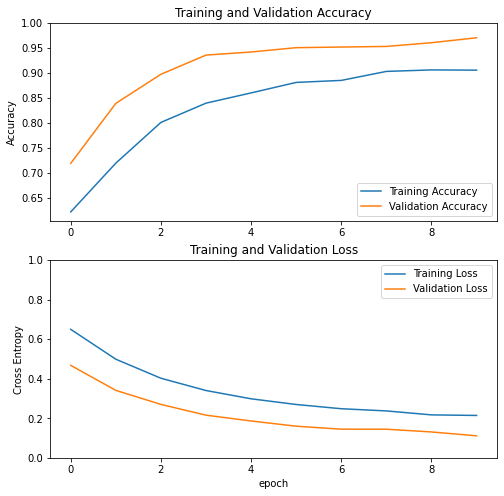

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

The validation metrics are clearly better than the training metrics because the the DN and Dropout layers affect the accuracy during training but they are actually turned off during the calculation of the validation loss. 

Also the validation metrics see a model that has trained slightly longer.

## Fine Tuning

One way to increase the performance is to train (fine-tune) the wights on the top layers of the pre-trained model alongside the training of the classifier added. The training process will force the weights to be tuned from generic feautre maps to features associated specifically with the Dataset.

**This should only be attempted if the top-level classifier has been trained with the pre-trained model set to non-trainable**

In [35]:
# unfreeze the top layers of the model

base_model.trainable = True

In [36]:
# show how many layers are in the basemodel
print("Number of layers in the base model: ", len(base_model.layers))

# fine tune for this number onwards
fine_tune_at = 110

# freeze all the layers before the tuning - this can be done with a for loop and slicing
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


## Compile the new model

In [37]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0     

In [39]:
len(model.trainable_variables)

47

## Continue Training the model

In [40]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         # initial epoch is the last one in the original training, use index -1
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 40s 564ms/step - loss: 0.1717 - accuracy: 0.9329 - val_loss: 0.0614 - val_accuracy: 0.9802
Epoch 11/20
63/63 [==============================] - 37s 584ms/step - loss: 0.1343 - accuracy: 0.9544 - val_loss: 0.0640 - val_accuracy: 0.9839
Epoch 12/20
63/63 [==============================] - 39s 606ms/step - loss: 0.1124 - accuracy: 0.9559 - val_loss: 0.0429 - val_accuracy: 0.9839
Epoch 13/20
63/63 [==============================] - 38s 604ms/step - loss: 0.1005 - accuracy: 0.9545 - val_loss: 0.0430 - val_accuracy: 0.9851
Epoch 14/20
63/63 [==============================] - 42s 655ms/step - loss: 0.0878 - accuracy: 0.9618 - val_loss: 0.0331 - val_accuracy: 0.9913
Epoch 15/20
63/63 [==============================] - 41s 649ms/step - loss: 0.0732 - accuracy: 0.9729 - val_loss: 0.0355 - val_accuracy: 0.9889
Epoch 16/20
63/63 [==============================] - 38s 601ms/step - loss: 0.0798 - accuracy: 0.9682 - val_loss: 0.0394 - val_accuracy:

In [41]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

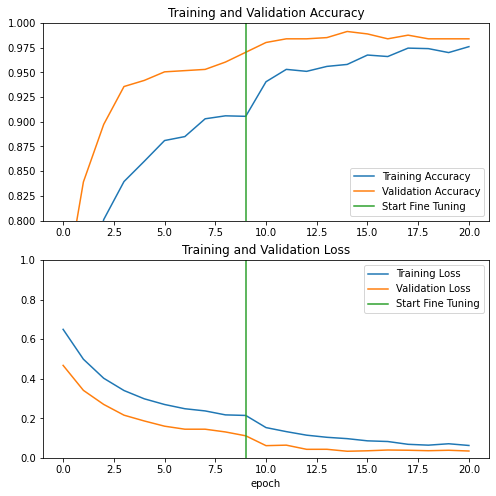

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [43]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 3s 299ms/step - loss: 0.0269 - accuracy: 0.9896
Test accuracy : 0.9895833134651184


## Predict using model

Predictions:
 [0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 0 1 1 1 1 0 0 1]
Labels:
 [0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 0 1 1 1 1 0 0 1]


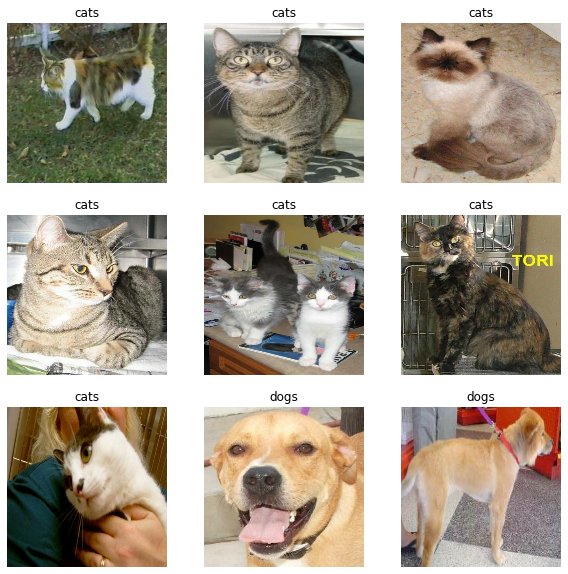

In [44]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

## Summary

When working with small datasets, it is common practice to take advantage of features learned by a model trained on a larger dataset in the same domain.

This is done by **instantiating the pre-trained model and adding a fully-connected classifier on top**.

The pre-trained model is then **frozen** and only the weights of the classifier get updated during training.

To further improve the performance, you can unfreeze some of the top layers and retune the weights whilst training on the new, smaller dataset.